In [1]:
import array
from array import array
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.signal import find_peaks
import numpy as np
from math import sqrt
import fnmatch
import os

In [2]:
#путь к директории с набранными данными
#pathIn = "C:/Users/Nuclab/Desktop/dataLab7/spectrometr"
pathIn = "/home/ovtin/Dropbox/NSU/AcceleratorPhysics/NuclearLabs/Lab7/dataLab7/spectrometr"

#имена файлов для анализа
fileName1 = "BGO_53,98V_40dB_trh40mV_152Eu_histo.txt"
fileName2 = "LYSO_53,98V_40dB_trh40mV_152Eu_histo.txt"
fileName3 = "CsI_53,98V_40dB_trh40mV_152Eu_histo.txt"

#укажите список файла которые необходимо проанализировать (от одного до нескольких)
#listFiles = [fileName2]
listFiles = [fileName1,fileName2,fileName3]
#число фотопиков в файлах - соответсвует 
listPhotoPeaks = [6,6,6]     

#включение/отключения приближения отображения по осям
XZoom = True
YZoom = False
Xleft = []; Xright = []; Ybottom = []; Ytop = []

#ручная установка положения пика / или использование автоматического поиска (плохо ищет пики)
handle = True
#handle = False

enPeaks = []
peaks = []; p_board1 = []; p_board2 = []
outSpectr = []; outCalADCScale = []; outEnRes = []; outNphedet = []

if fnmatch.filter(listFiles, '*BGO*'):
    ##линии излучения изотопа(Eu152): 40 keV, 122 keV, 244 keV, 344 keV, 778 keV, 1098 keV, 1408 keV 
    enPeaks.append([1.408,1.098,0.778,0.344,0.244,0.122])
    #установка диапазона приближения по оси X
    Xleft.append([237800.0])  
    Xright.append([243000.0])
    Ybottom.append([0.])  
    Ytop.append([1000.0])
    #ручная установка значений положения пиков излучения изотопа
    peaks.append([238700.,239475.,240300.,241400.,241650.,242000.])
    #задание границ диапазона для подгонки -+ от положения пика
    p_board1.append([350.,150.,250.,180.,120.,170.])
    p_board2.append([350.,200.,270.,160.,130.,80.])
    #имена сохраняемых картинок 
    outSpectr.append('spectr_152Eu_BGO.png')
    outCalADCScale.append('EnergyCalibration_152Eu_BGO.png')
    outEnRes.append('EnergyResolution_152Eu_BGO.png')
    outNphedet.append('Nphe_determination_152Eu_BGO.png')
    
if fnmatch.filter(listFiles, '*LYSO*'):
    ##линии излучения изотопа(Eu152): 40 keV, 122 keV, 244 keV, 344 keV, 778 keV, 1098 keV, 1408 keV 
    enPeaks.append([1.408,1.098,0.778,0.344,0.244,0.122])
    #установка диапазона приближения по оси X
    Xleft.append([228000.0])  
    Xright.append([243000.0]) 
    Ybottom.append([0.])  
    Ytop.append([1000.0])
    #ручная установка значений положения пиков излучения изотопа
    peaks.append([230000.,232500.,235200.,238900.,239870.,241200.])
    #задание границ диапазона для подгонки -+ от положения пика
    p_board1.append([800.,700.,750.,450.,350.,320.])
    p_board2.append([800.,700.,700.,450.,350.,280.])
    #имена сохраняемых картинок 
    outSpectr.append('spectr_152Eu_LYSO.png')
    outCalADCScale.append('EnergyCalibration_152Eu_LYSO.png')
    outEnRes.append('EnergyResolution_152Eu_LYSO.png')
    outNphedet.append('Nphe_determination_152Eu_LYSO.png')

if fnmatch.filter(listFiles, '*CsI*'):
    ##линии излучения изотопа(Eu152): 40 keV, 122 keV, 244 keV, 344 keV, 778 keV, 1098 keV, 1408 keV 
    enPeaks.append([1.408,1.098,0.778,0.344,0.244,0.122])
    #установка диапазона приближения по оси X
    Xleft.append([465000.0])  
    Xright.append([482000.0]) 
    Ybottom.append([0.])  
    Ytop.append([1000.0])
    #ручная установка значений положения пиков излучения изотопа
    peaks.append([466050.,468500.,471700.,476400.,477600.,479100.])
    #задание границ диапазона для подгонки -+ от положения пика
    p_board1.append([700.,900.,1000.,1000.,500.,500.])
    p_board2.append([1100.,1100.,1000.,800.,500.,250.])
    #имена сохраняемых картинок 
    outSpectr.append('spectr_152Eu_CsI.png')
    outCalADCScale.append('EnergyCalibration_152Eu_CsI.png')
    outEnRes.append('EnergyResolution_152Eu_CsI.png')
    outNphedet.append('Nphe_determination_152Eu_CsI.png')

#задание цвета линий указывающих диапащон подгонки для пика    
colors = ['c','k','b','g','m','y','d']

#создание директории для сохранения результатов
pathOut = pathIn + '/' + 'results'
if not os.path.exists(pathOut):
    os.mkdir(pathOut)

In [3]:
#определение функций для подгонки данных
def Gauss(x, a, x0, s):
    return a*np.exp(-((x-x0)/s)**2)

def DoubleGauss(x, a1, x01, s1, a2, x02, s2):
    return Gauss(x, a1, x01, s1) + Gauss(x, a2, x02, s2)

def nGauss(x, *p):
    n = len(p)/3
    res = 0
    for i in range(n):
        res += Gauss(x, p[i*3], p[i*3+1], p[i*3+2])
    return res

def plotAllGauss(x, p):
    n = len(p)//3
    for i in range(n):
        plt.plot(x, Gauss(x,p[i*3],p[i*3+1],p[i*3+2]), 'b', linewidth=0.5)
        
def fitline(x, A, B): 
    return A*x + B

0 : Анализируем данные из файла: BGO_53,98V_40dB_trh40mV_152Eu_histo.txt
Общее число пиков установленное для анализа: 6
--------------------------
0 peak, X position = 238700.0
0 peak: Параметры гауссианов:  [2.73585947e+01 2.38700000e+05 9.30088234e+02 8.02501636e+01
 2.38700000e+05 1.78867473e+02]
Стандартное отклонение:  14.388866795752588
Квадрат коэффициента корреляции:  0.7963722787960233
mean= 238699.99999999997 +- 8.792649301894233 sigma= 178.86747310109968 +- 58.40651793526019
--------------------------
1 peak, X position = 239475.0
1 peak: Параметры гауссианов:  [5.81145616e+01 2.39475000e+05 9.25784972e+01 2.15702398e+02
 2.39475000e+05 9.99601537e+05]
Стандартное отклонение:  19.99470030129871
Квадрат коэффициента корреляции:  0.4941760495687313
mean= 239474.99999999997 +- 14.69171279728775 sigma= 92.57849721033384 +- 41.180092833732715
--------------------------
2 peak, X position = 240300.0
2 peak: Параметры гауссианов:  [7.94777681e+01 2.40281625e+05 8.92124486e+01 3.609

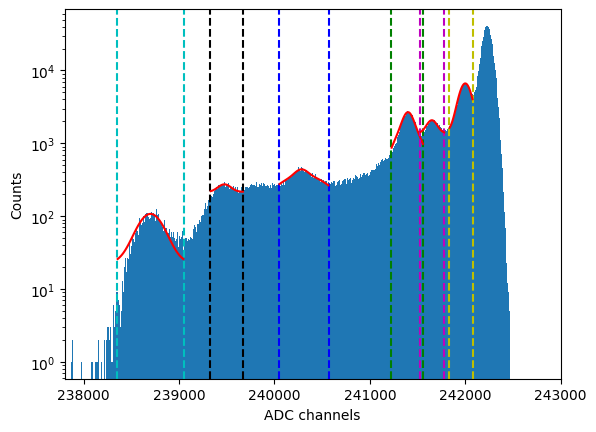

y =  -2563.8358624344964 *x +  242286.75087088035


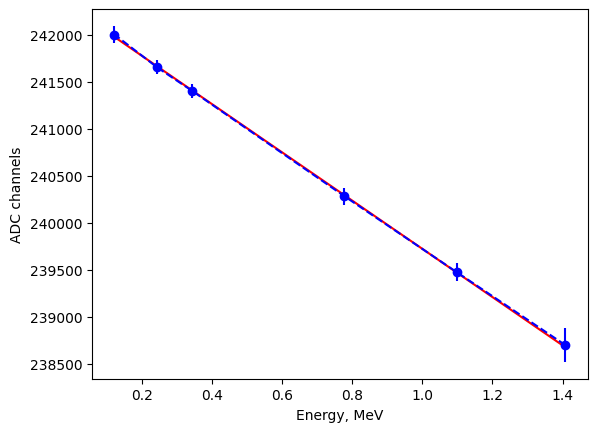

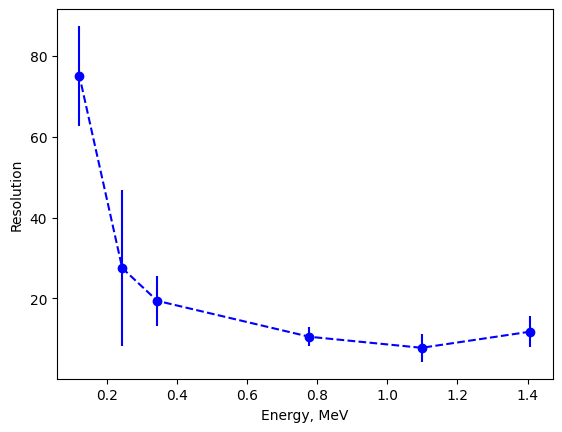

y =  0.00949443090707398 *x +  21551.646879568587


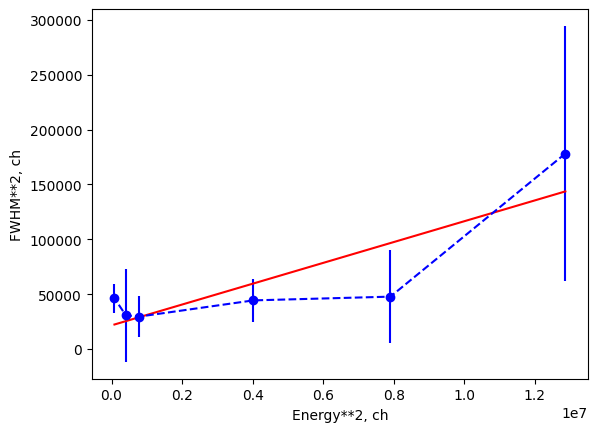

Nph.e. =  69.79881221803875 +- 21.286708207205322
************************************************************
1 : Анализируем данные из файла: LYSO_53,98V_40dB_trh40mV_152Eu_histo.txt
Общее число пиков установленное для анализа: 6
--------------------------
0 peak, X position = 230000.0
0 peak: Параметры гауссианов:  [1.12356353e+01 2.30000000e+05 1.50257631e+05 1.81400763e+01
 2.30000000e+05 4.40123177e+02]
Стандартное отклонение:  5.80055354620824
Квадрат коэффициента корреляции:  0.5222029363550579
mean= 229999.99999999997 +- 25.043070223997862 sigma= 440.1231770590027 +- 189.50874817409428
--------------------------
1 peak, X position = 232500.0
1 peak: Параметры гауссианов:  [2.83174633e+01 2.32500000e+05 3.57529026e+02 6.25859965e+01
 2.32500000e+05 9.99958676e+05]
Стандартное отклонение:  13.42130042061105
Квадрат коэффициента корреляции:  0.3433366375654144
mean= 232499.99999999997 +- 31.08285814329965 sigma= 357.52902599946503 +- 189.08905527217
--------------------------
2 p

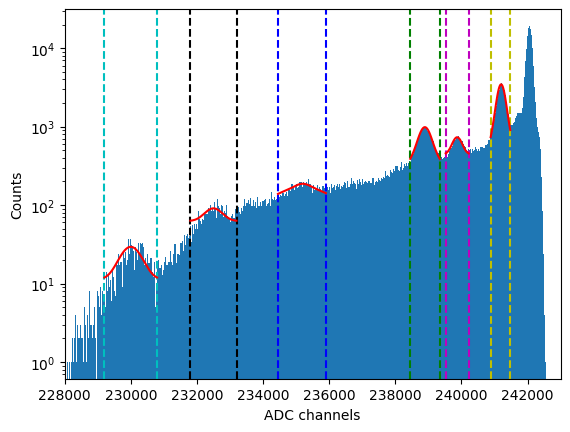

y =  -8782.939223146284 *x +  242124.1084542867


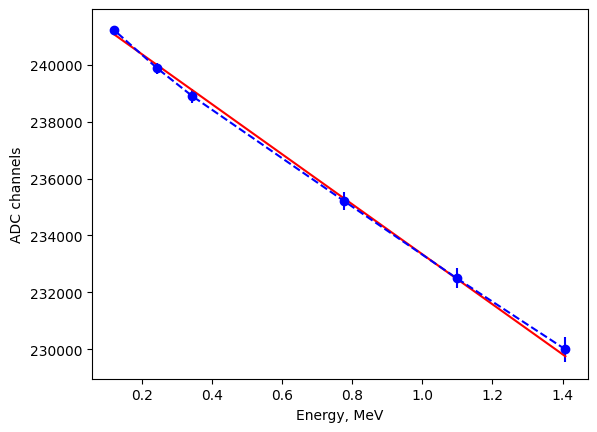

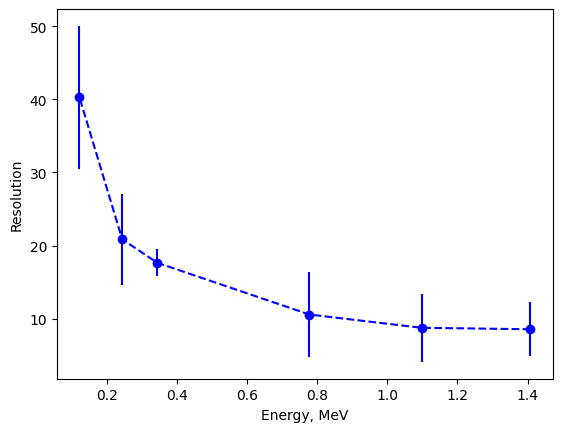

y =  0.005939263522162186 *x +  201187.06153861873


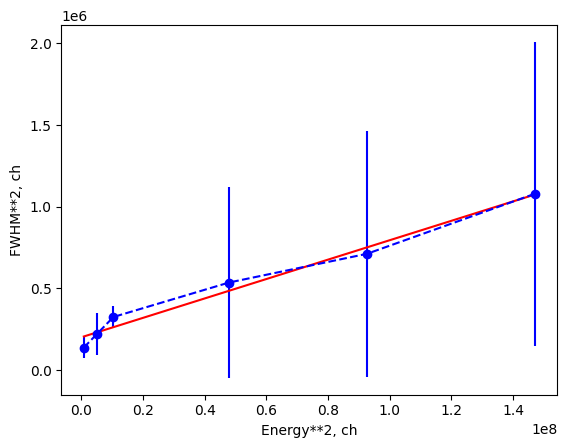

Nph.e. =  111.57949087915608 +- 8.065605721363218
************************************************************
2 : Анализируем данные из файла: CsI_53,98V_40dB_trh40mV_152Eu_histo.txt
Общее число пиков установленное для анализа: 6
--------------------------
0 peak, X position = 466050.0
0 peak: Параметры гауссианов:  [1.35014074e+00 4.66050000e+05 9.99993831e+05 2.66116261e+00
 4.66050000e+05 3.43681260e+02]
Стандартное отклонение:  1.7569179140145583
Квадрат коэффициента корреляции:  0.2231847985865819
mean= 466049.99999999994 +- 39.4171001969193 sigma= 343.68126045993813 +- 91.02613392294947
--------------------------
1 peak, X position = 468500.0
1 peak: Параметры гауссианов:  [4.77232485e+00 4.68500000e+05 3.73526211e+02 8.79279785e+00
 4.68500000e+05 9.99999094e+05]
Стандартное отклонение:  4.903527816825342
Квадрат коэффициента корреляции:  0.10553796131975055
mean= 468499.99999999994 +- 58.492491694303126 sigma= 373.52621112746476 +- 165.61184344715372
--------------------------

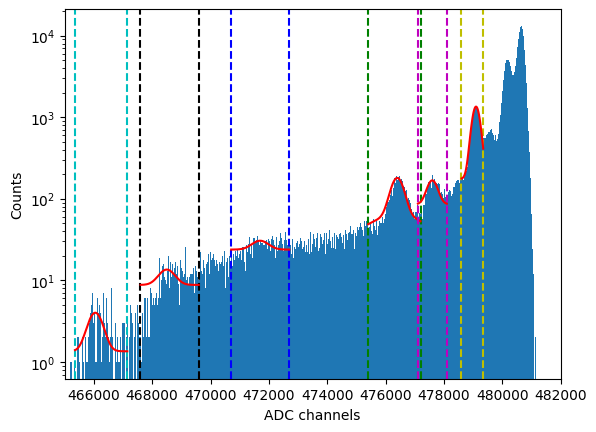

y =  -10347.6677398289 *x +  480180.3092807121


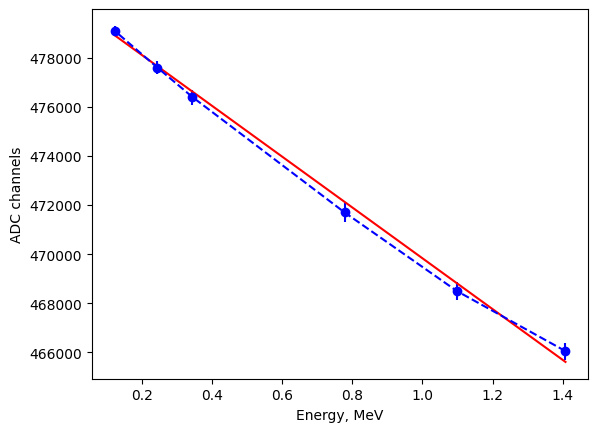

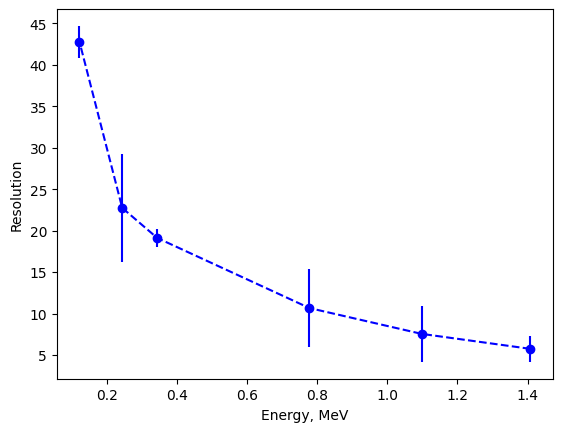

y =  0.002033447353627307 *x +  409682.5944785379


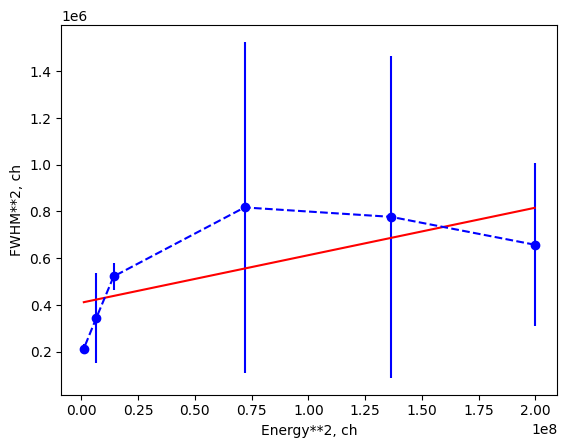

Nph.e. =  325.8997577772848 +- 172.8509675825779
************************************************************


In [4]:
for fileName in listFiles:    
    x,y = np.array([]), np.array([])
    energy = np.array([])
    ADCcharray, errADCcharray = np.array([]),np.array([])
    enRes, errenRes = np.array([]),np.array([])
    E2, deltaE2, errdeltaE2 = np.array([]),np.array([]),np.array([]) 
    meanarray = []; errmeanarray = []; 
    sigmaarray = []; errsigmaarray = []
       
    index = listFiles.index(fileName)
    print(index,': Анализируем данные из файла:',fileName)

    try:
        file1 = open(pathIn + "/" + fileName)
        for line1 in file1.readlines():
            line1 = line1.replace(',','.')
            b = line1.split()
            b[0] = float(b[0])
            b[1] = float(b[1])
            x = np.append(x, b[0])
            y = np.append(y, b[1])
    except FileNotFoundError:
        print('Can`t open the file',fileName,'. No such file or directory')
    except ValueError:
        print('It`s not a number. Check the data in the file')
    except IndexError:
        print('The index is not in the range of elements. Check the data in the file')
    
    #plt.plot(x, y,'o',markersize=2)  
    plt.bar(x, y, width=8.0)
    plt.xlabel('ADC channels')
    plt.ylabel('Counts')
    plt.yscale('log')
    
    if XZoom:
        plt.xlim([Xleft[index][0], Xright[index][0]])  
    if YZoom:
        plt.ylim([Ybottom[index][0], Ytop[index][0]])  

    #автоматический поис пиков
    if not handle:
        thresh_top    = np.median(y) - 2.0 * np.std(y)    
        i_peaks, _ = find_peaks(y,  height=thresh_top, width=6, distance=30)
        print('i_peaks=',i_peaks,' x[i_peaks]=',x[i_peaks],' y[i_peaks]=',y[i_peaks])
        print('len(i_peaks)=',len(i_peaks),' x_lastPeak=',x[i_peaks][len(i_peaks)-1])
    
    ##установка числа анализируемых пиков
    npeaks = listPhotoPeaks[index]
    print('Общее число пиков установленное для анализа:',npeaks)
        
    for n in range(npeaks):
        if not handle:
            peak = x[i_peaks][n]
            board1 = peak-p_board1[index][n]
            board2 = peak+p_board2[index][n]   
            #plt.plot([min(y), max(y)], [thresh_top, thresh_top],'--',  color='r', label='peaks-threshold') # Plot threshold
            plt.plot(x[i_peaks], y[i_peaks], 'x')
    
        if handle: 
            peak = peaks[index][n]
            board1 = peaks[index][n]-p_board1[index][n]
            board2 = peaks[index][n]+p_board2[index][n]
        
        print('--------------------------')    
        print(n,'peak, X position =',peak)    
        
        plt.axvline(x=board1, color=colors[n], ls='--')           
        plt.axvline(x=board2, color=colors[n], ls='--')           

        #установка диапазона подгонки, начальных значений, подгонка
        mask = (x>board1) & (x<board2)
        x1 = x[mask]
        y1 = y[mask]
        init_valsp = [.025, peak-100, 30., .025, peak-100, 30.]
        p, cov = curve_fit(DoubleGauss, x1, y1, p0=init_valsp, bounds=(0, [50000., peak, 1000000., 50000., peak, 1000000.]))
        ##p, cov = curve_fit(DoubleGauss, x1, y1, p0=init_valsp, bounds=([0., peak-1000., 0., 0., peak-1000., 0.]
#, [50000., 10000., 1000000., 50000., 10000., 1000000.]))
        fit_y = DoubleGauss(x1, *p)    
        print(n, "peak: Параметры гауссианов: ",p)
        #print(n, "peak: Ковариационная матрица: ",cov)
        #оценка погрешности аппроксимации и достоверности модели
        print("Стандартное отклонение: ", np.std(y1-fit_y))
        slope, ic, r_value, p_value, std_err = stats.linregress(y1,fit_y)
        print("Квадрат коэффициента корреляции: ", r_value**2)
        dp = \
          [np.sqrt(cov[j,j]) for j in range(p.size)]

        plt.plot(x1, fit_y, 'r')

        sigma = p[5]
        errsigma = dp[5]
        mean = p[4]
        errmean = dp[4]
        if p[2]<p[5]:
            sigma = p[2]        
            errsigma = dp[2]        
            mean = p[1]
            errmean = dp[1]
            
        meanarray.append(mean)
        sigmaarray.append(sigma)
        errmeanarray.append(errmean)
        errsigmaarray.append(errsigma)
        print('mean=',mean,'+-',errmean,'sigma=',sigma,'+-',errsigma)
        ADCcharray = np.append(ADCcharray, mean)
        errADCcharray = np.append(errADCcharray, sigma)
        
        energy = np.append(energy, enPeaks[index][n])
        
    plt.savefig(pathOut + '/' + outSpectr[index])    
    plt.show() 
    
    plt.errorbar(energy, ADCcharray, yerr=errADCcharray, fmt='ob--')
    par1, pcov = curve_fit(fitline, energy, ADCcharray, sigma = errADCcharray)
    print('y = ',par1[0],'*x + ',par1[1])
    fit_l1 = fitline(energy, *par1)
    plt.plot(energy, fit_l1, 'r')
    plt.xlabel('Energy, MeV')
    plt.ylabel('ADC channels')
    plt.savefig(pathOut + '/' + outCalADCScale[index])
    plt.show()

    for j in range(len(meanarray)):
        enRes = np.append(enRes, 2.36*sigmaarray[j]*100./(par1[1]-meanarray[j]))
        errenRes = np.append(errenRes, ((par1[1]-meanarray[j])*2.36*errsigmaarray[j]*100. + 2.36*sigmaarray[j]*100.*errmeanarray[j])/(par1[1]-meanarray[j])**2)   
        deltaE2 = np.append(deltaE2, pow(2.36*sigmaarray[j],2))
        errdeltaE2 = np.append(errdeltaE2, pow(2.36,2)*2*sigmaarray[j]*errsigmaarray[j])
        E2 = np.append(E2,pow((par1[1]-meanarray[j]),2))
    
    plt.errorbar(energy, enRes, yerr=errenRes, fmt='ob--')
    plt.xlabel('Energy, MeV')
    plt.ylabel('Resolution')
    plt.savefig(pathOut + '/' + outEnRes[index])
    plt.show()    
    
    plt.errorbar(E2, deltaE2, yerr=errdeltaE2 , fmt='ob--')
    par2, pcov2 = curve_fit(fitline, E2, deltaE2)
    print('y = ',par2[0],'*x + ',par2[1])
    fit_l2 = fitline(E2, *par2)
    dpar2 = \
          [np.sqrt(pcov2[j,j]) for j in range(par2.size)]
    plt.plot(E2, fit_l2, 'r')
    plt.xlabel('Energy**2, ch')
    plt.ylabel('FWHM**2, ch')
    plt.savefig(pathOut + '/' + outNphedet[index])
    plt.show()   
    
    print('Nph.e. = ',2.35**2*0.12/par2[0],'+-',2.35**2*0.12*dpar2[0]/(par2[0]**2)) 
    print('************************************************************')